In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.metrics import mean_absolute_error, mean_squared_error

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-03-01 to 2020-10-27
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  241 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21',
               '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
               '2020-10-26', '2020-10-27'],
              dtype='datetime64[ns]', name='date', length=241, freq='D')

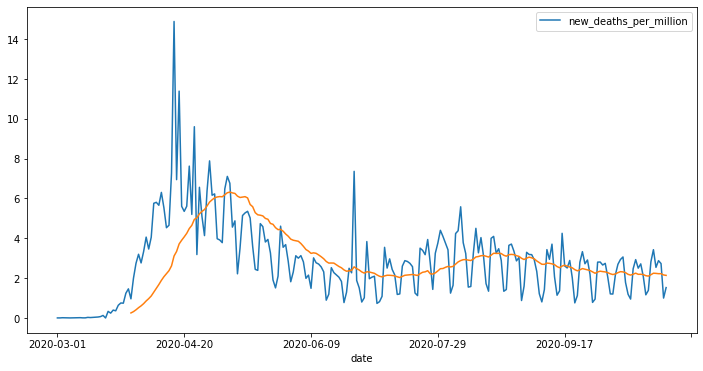

In [2]:
df = pd.read_csv('Datasets/owid-covid-data.csv')

df.columns
covid_df = df.location.unique()

indexer = df[df['location']=='United States'].index
covid_df = df.loc[indexer, 'date':'new_deaths_per_million']
covid_df = covid_df.dropna()
covid_df.set_index('date', inplace=True)
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d')
covid_df.info() # 241 : 192 Training : 49 Test

train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

covid_df.index

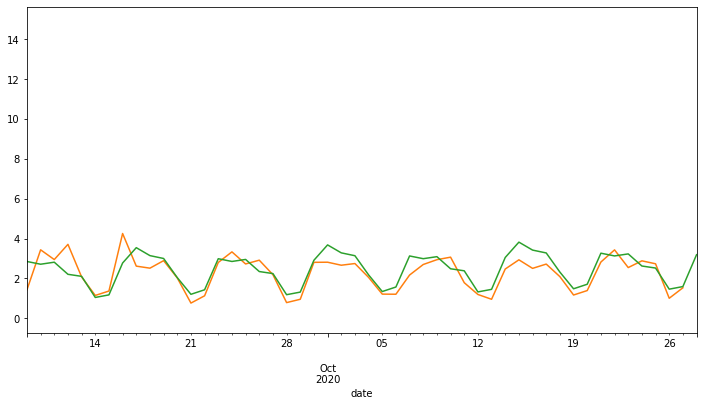

In [3]:
# The Holt - Winters Method actually models 3 aspects of the time series being the average, trend and seasonality. 
# In doing so it tries to predict the future provided the series is seasonal and repetitive over time.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()

prediction = fit_model.forecast(50) # 50 days into the future
prediction

train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-10-28'])

In [4]:
def mae(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return np.mean(np.abs(y1_np - y2_np), axis=axis)

mae(test_df, prediction, None)

mean_absolute_error(test_df, prediction)

0.8144854298321421

In [5]:
def mse(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return ((y1_np - y2_np) ** 2).mean(axis=axis)

mse(test_df, prediction, None)
    
mean_squared_error(test_df, prediction)

0.9724807127874934

In [6]:
np.sqrt(mean_squared_error(test_df, prediction))

0.9861443671123885

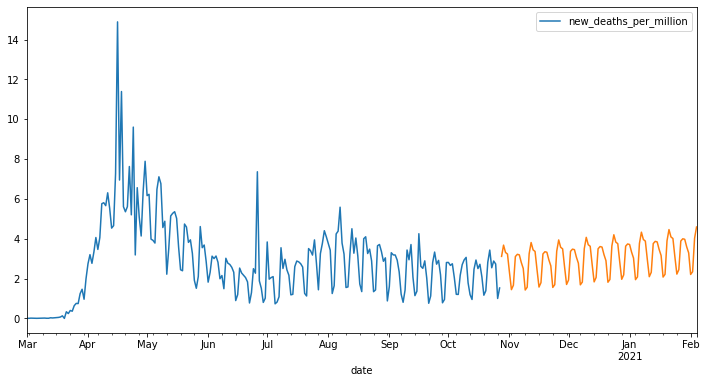

In [7]:
covid_model = ExponentialSmoothing(covid_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()

covid_forecast = covid_model.forecast(100) # 100 days into the future

covid_df.plot(figsize=(12,6))
covid_forecast.plot()